Projekt - DEA - Graniczna Analiza Danych

In [1]:
# importy i input
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pulp import *
from tabulate import tabulate

inputs = pd.read_csv('inputs.csv', index_col=0, delimiter=';')
outputs = pd.read_csv('outputs.csv', index_col=0, delimiter=';')
samples = pd.read_csv('samples_homework.csv', delimiter=';')

In [2]:
efficiency_scores = {}
reference_units = {}
adjustments = {}
super_efficiency_scores = {}
cross_efficiency_scores = {DMU: [] for DMU in inputs.index}
expected_efficiency = {}

In [13]:
# Obliczanie efektywności i superefektywności - poprawione?
for DMUo in inputs.index:
    # Model klasyczny (efektywność)
    problem = LpProblem(f"Efficiency_{DMUo}", LpMinimize)
    lambdas = LpVariable.dicts("Lambda", (i for i in inputs.index), lowBound=0)
    theta = LpVariable("theta", lowBound=0, upBound=1)

    problem += theta

    for input_metric in inputs.columns:
        problem += lpSum([lambdas[i] * inputs.loc[i, input_metric] for i in inputs.index]) <= theta * inputs.loc[DMUo, input_metric]

    for output_metric in outputs.columns:
        problem += lpSum([lambdas[i] * outputs.loc[i, output_metric] for i in inputs.index]) >= outputs.loc[DMUo, output_metric]

    problem.solve(PULP_CBC_CMD(msg=False))

    if LpStatus[problem.status] == 'Optimal':
        efficiency_score = value(theta)
        efficiency_scores[DMUo] = efficiency_score

        if efficiency_score < 1:
            # Zapisz jednostki odniesienia (HCU)
            reference_units[DMUo] = {}
            adjustments[DMUo] = {}
            for i in inputs.index:
                if lambdas[i].varValue > 0:
                    reference_units[DMUo][i] = lambdas[i].varValue

            # Oblicz poprawki
            for input_metric in inputs.columns:
                optimal_input = sum(lambdas[i].varValue * inputs.loc[i, input_metric] for i in inputs.index)
                adjustments[DMUo][input_metric] = inputs.loc[DMUo, input_metric] - optimal_input

            # Superefektywność = efektywność (dla nieefektywnych jednostek)
            super_efficiency_scores[DMUo] = efficiency_score

        else:
            # Model superefektywności (tylko dla efektywnych jednostek)
            super_problem = LpProblem(f"SuperEfficiency_{DMUo}", LpMinimize)
            # tylko inne jednostki
            peer_dmus = [i for i in inputs.index if i != DMUo]
            super_lambdas = LpVariable.dicts("SuperLambda", peer_dmus, lowBound=0)
            super_theta = LpVariable("super_theta", lowBound=0)

            super_problem += super_theta

            # Ograniczenia: wejścia — pomnóż wejścia peerów przez lambdy, ale pomiń DMUo!
            for input_metric in inputs.columns:
                super_problem += lpSum([
                    super_lambdas[i] * inputs.loc[i, input_metric] for i in peer_dmus
                ]) <= super_theta * inputs.loc[DMUo, input_metric]

            # Ograniczenia: wyjścia — peerzy muszą osiągać co najmniej to co DMUo
            for output_metric in outputs.columns:
                super_problem += lpSum([
                    super_lambdas[i] * outputs.loc[i, output_metric] for i in peer_dmus
                ]) >= outputs.loc[DMUo, output_metric]

            super_problem.solve(PULP_CBC_CMD(msg=False))

            if LpStatus[super_problem.status] == 'Optimal':
                theta_val = value(super_theta)
                if theta_val and theta_val > 1e-6:
                    super_eff = 1 / theta_val
                    if super_eff >= 1:
                        super_efficiency_scores[DMUo] = super_eff
                    else:
                        print(f"Warning: Superefektywność dla {DMUo} < 1 ({super_eff:.3f}) — to nie powinno się zdarzyć!")
                        super_efficiency_scores[DMUo] = np.nan
                else:
                    super_efficiency_scores[DMUo] = np.nan
            else:
                print(f"Superefektywność: problem dla {DMUo} jest nierozwiązywalny")
    else:
        print(f"Efektywność: problem dla {DMUo} jest nierozwiązywalny")


In [4]:
# Tabela efektywności
df_efficiency = pd.DataFrame.from_dict(efficiency_scores, orient='index', columns=['Efektywność'])
df_efficiency.index.name = 'Lotnisko'

# Tabela superefektywności
df_super = pd.DataFrame.from_dict(super_efficiency_scores, orient='index', columns=['Superefektywność'])
df_super.index.name = 'Lotnisko'

# Tabela poprawek (adjustments)
df_adjustments = pd.DataFrame.from_dict(adjustments, orient='index')
df_adjustments.index.name = 'Lotnisko'

# Oblicz rzeczywiste wartości wejściowe dla HCU (hipotetycznej jednostki odniesienia)
hcu_inputs = {}

for dmu, lambda_dict in reference_units.items():
    hcu_inputs[dmu] = {}
    for input_metric in inputs.columns:
        hcu_inputs[dmu][input_metric] = sum(
            lambda_dict.get(k, 0) * inputs.loc[k, input_metric] for k in inputs.index
        )

# Przekształć do DataFrame
df_hcu_inputs = pd.DataFrame.from_dict(hcu_inputs, orient='index')
df_hcu_inputs.index.name = "Lotnisko"
df_hcu_inputs.columns = [f"{col}_HCU" for col in df_hcu_inputs.columns]
df_adjustments.columns = [f"{col}_Δ" for col in df_adjustments.columns]

# Połącz dane
df_hcu_full = df_hcu_inputs.join(df_adjustments, how="left")


# Złączenie efektywności i superefektywności
df_zad2 = df_hcu_inputs.join(df_adjustments, how='left')


# Wyświetlenie
print("Tabela efektywności:")
print(tabulate(df_efficiency.reset_index(), headers='keys', tablefmt='github'))

print("\nTabela superefektywności:")
print(tabulate(df_super.reset_index(), headers='keys', tablefmt='github'))

print("\nTabela jednostek odniesienia (HCU):")
print(tabulate(df_hcu_inputs.reset_index(), headers='keys', tablefmt='github'))

print("\nTabela poprawek:")
print(tabulate(df_adjustments.reset_index(), headers='keys', tablefmt='github'))

print("\nTabela HCU i poprawki:")
print(tabulate(df_zad2.reset_index(), headers='keys', tablefmt='github'))

Tabela efektywności:
|    | Lotnisko   |   Efektywność |
|----|------------|---------------|
|  0 | WAW        |      1        |
|  1 | KRK        |      1        |
|  2 | KAT        |      0.591209 |
|  3 | WRO        |      1        |
|  4 | POZ        |      0.799801 |
|  5 | LCJ        |      0.300036 |
|  6 | GDN        |      1        |
|  7 | SZZ        |      0.270787 |
|  8 | BZG        |      1        |
|  9 | RZE        |      0.409183 |
| 10 | IEG        |      0.258475 |

Tabela superefektywności:
|    | Lotnisko   |   Superefektywność |
|----|------------|--------------------|
|  0 | WAW        |         nan        |
|  1 | KRK        |         nan        |
|  2 | KAT        |           0.591209 |
|  3 | WRO        |         nan        |
|  4 | POZ        |           0.799801 |
|  5 | LCJ        |           0.300036 |
|  6 | GDN        |         nan        |
|  7 | SZZ        |           0.270787 |
|  8 | BZG        |         nan        |
|  9 | RZE        |           0.4

In [5]:
# importy do LaTeXa do sprawka ;)
print(df_efficiency.to_latex(
    header=["Efektywność"],
    index_names=True,
    column_format="c|c",
    float_format="%.3f"
))

\begin{tabular}{c|c}
\toprule
 & Efektywność \\
Lotnisko &  \\
\midrule
WAW & 1.000 \\
KRK & 1.000 \\
KAT & 0.591 \\
WRO & 1.000 \\
POZ & 0.800 \\
LCJ & 0.300 \\
GDN & 1.000 \\
SZZ & 0.271 \\
BZG & 1.000 \\
RZE & 0.409 \\
IEG & 0.258 \\
\bottomrule
\end{tabular}



In [6]:
print(df_zad2.to_latex(
    index_names=True,
    column_format="c|" + "c" * len(df_zad2.columns),
    float_format="%.2f"
).replace("\\toprule", "\\hline")
 .replace("\\midrule", "\\hline")
 .replace("\\bottomrule", "\\hline"))


\begin{tabular}{c|cccccccc}
\hline
 & i1_HCU & i2_HCU & i3_HCU & i4_HCU & i1_Δ & i2_Δ & i3_Δ & i4_Δ \\
Lotnisko &  &  &  &  &  &  &  &  \\
\hline
KAT & 2.13 & 18.92 & 33.94 & 4.40 & 1.47 & 13.08 & 23.46 & 6.10 \\
POZ & 1.20 & 8.00 & 19.20 & 1.93 & 0.30 & 2.00 & 4.80 & 2.07 \\
LCJ & 0.18 & 2.78 & 7.20 & 0.47 & 0.42 & 9.22 & 16.80 & 3.43 \\
SZZ & 0.19 & 2.71 & 6.96 & 0.47 & 0.51 & 7.29 & 18.74 & 1.43 \\
RZE & 0.25 & 2.46 & 4.62 & 0.54 & 0.35 & 3.54 & 6.68 & 2.16 \\
IEG & 0.03 & 0.39 & 1.11 & 0.06 & 0.07 & 9.61 & 62.29 & 2.94 \\
\hline
\end{tabular}



In [7]:
print(df_super.to_latex(
    header=["Superefektywność"],
    index_names=True,
    column_format="c|c",
    float_format="%.3f"
))


\begin{tabular}{c|c}
\toprule
 & Superefektywność \\
Lotnisko &  \\
\midrule
WAW & NaN \\
KRK & NaN \\
KAT & 0.591 \\
WRO & NaN \\
POZ & 0.800 \\
LCJ & 0.300 \\
GDN & NaN \\
SZZ & 0.271 \\
BZG & NaN \\
RZE & 0.409 \\
IEG & 0.258 \\
\bottomrule
\end{tabular}



In [8]:
# Assuming the necessary data frames 'inputs' and 'outputs' are already defined
samples = pd.read_csv('samples_homework.csv')
cross_efficiency_matrix = pd.DataFrame(index=inputs.index, columns=inputs.index)

# Calculate cross-efficiency for each DMU
for DMUo in inputs.index:
    for DMU in inputs.index:
        if DMU != DMUo:
            problem = LpProblem(f"CrossEfficiency_{DMUo}_using_{DMU}", LpMinimize)
            lambdas = LpVariable.dicts("Lambda", (i for i in inputs.index), lowBound=0)
            theta = LpVariable("theta", lowBound=0, upBound=1)

            problem += theta

            for input_metric in inputs.columns:
                problem += lpSum([lambdas[i] * inputs.loc[i, input_metric] for i in inputs.index]) <= theta * inputs.loc[DMUo, input_metric]

            for output_metric in outputs.columns:
                problem += lpSum([lambdas[i] * outputs.loc[i, output_metric] for i in inputs.index]) >= outputs.loc[DMUo, output_metric]

            problem.solve(PULP_CBC_CMD(msg=False))

            if LpStatus[problem.status] == 'Optimal':
                cross_efficiency_matrix.loc[DMUo, DMU] = value(theta)
        else:
            cross_efficiency_matrix.loc[DMUo, DMU] = 1  # Self-evaluation is always 1

# Calculate average cross-efficiency
cross_efficiency_matrix['CRavg'] = cross_efficiency_matrix.mean(axis=1)

# # Display the cross-efficiency matrix
# print("Cross-Efficiency Matrix:")
# print(cross_efficiency_matrix)

# Save the cross-efficiency matrix to a CSV file (optional)
cross_efficiency_matrix.to_csv('cross_efficiency_matrix.csv', index=True)

# Format the table for display
table_format = cross_efficiency_matrix.reset_index().to_markdown(index=False)
print(table_format)


| index   |      WAW |      KRK |      KAT |      WRO |      POZ |      LCJ |      GDN |      SZZ |      BZG |      RZE |      IEG |    CRavg |
|:--------|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
| WAW     | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        |
| KRK     | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        |
| KAT     | 0.591209 | 0.591209 | 1        | 0.591209 | 0.591209 | 0.591209 | 0.591209 | 0.591209 | 0.591209 | 0.591209 | 0.591209 | 0.628372 |
| WRO     | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        |
| POZ     | 0.799801 | 0.799801 | 0.799801 | 0.799801 | 1        | 0.799801 | 0.799801 | 0.799801 | 0.799801 | 0.799801 | 0.799801 | 0.8

In [10]:
# Create DataFrame for ranking
results_df = pd.DataFrame({
    'Efficiency': pd.Series(efficiency_scores),
    'SuperEfficiency': pd.Series(super_efficiency_scores),
    'ExpectedEfficiency': pd.Series(expected_efficiency)
})

# Rank units
results_df['EfficiencyRank'] = results_df['Efficiency'].rank(ascending=False)
results_df['SuperEfficiencyRank'] = results_df['SuperEfficiency'].rank(ascending=False)
results_df['ExpectedEfficiencyRank'] = results_df['ExpectedEfficiency'].rank(ascending=False)

# Sort DataFrame by ranks
efficiency_ranking = results_df.sort_values(by='EfficiencyRank').index.tolist()
super_efficiency_ranking = results_df.sort_values(by='SuperEfficiencyRank').index.tolist()
expected_efficiency_ranking = results_df.sort_values(by='ExpectedEfficiencyRank').index.tolist()

# Format rankings into the desired output
super_efficiency_str = " ≻ ".join(super_efficiency_ranking)
average_efficiency_str = " ≻ ".join(efficiency_ranking)
expected_efficiency_str = " ≻ ".join(expected_efficiency_ranking)

# Print the formatted rankings
print(f"Superefektywność: {super_efficiency_str}")
print(f"Średnia efektywność krzyżowa: {average_efficiency_str}")
print(f"Oczekiwana wartość efektywności: {expected_efficiency_str}")

Superefektywność: POZ ≻ KAT ≻ RZE ≻ LCJ ≻ SZZ ≻ IEG ≻ WAW ≻ KRK ≻ WRO ≻ GDN ≻ BZG
Średnia efektywność krzyżowa: WAW ≻ KRK ≻ WRO ≻ GDN ≻ BZG ≻ POZ ≻ KAT ≻ RZE ≻ LCJ ≻ SZZ ≻ IEG
Oczekiwana wartość efektywności: WAW ≻ KRK ≻ KAT ≻ WRO ≻ POZ ≻ LCJ ≻ GDN ≻ SZZ ≻ BZG ≻ RZE ≻ IEG


Efficiency Distribution for Each DMU:
     [0-0.2]  [0.2-0.4]  [0.4-0.6]  [0.6-0.8]  [0.8-1.0]  EE
WAW        0          0          0          0          0 NaN
KRK        0          0          0          0          0 NaN
KAT        0          0          0          0          0 NaN
WRO        0          0          0          0          0 NaN
POZ        0          0          0          0          0 NaN
LCJ        0          0          0          0          0 NaN
GDN        0          0          0          0          0 NaN
SZZ        0          0          0          0          0 NaN
BZG        0          0          0          0          0 NaN
RZE        0          0          0          0          0 NaN
IEG        0          0          0          0          0 NaN


C:\Users\User\AppData\Local\Temp\ipykernel_22780\1770741904.py:26: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[idx].set_ylim(0, max(distribution_df.max()))
C:\Users\User\AppData\Local\Temp\ipykernel_22780\1770741904.py:26: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[idx].set_ylim(0, max(distribution_df.max()))
C:\Users\User\AppData\Local\Temp\ipykernel_22780\1770741904.py:26: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[idx].set_ylim(0, max(distribution_df.max()))
C:\Users\User\AppData\Local\Temp\ipykernel_22780\1770741904.py:26: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[idx].set_ylim(0, max(distribution_df.max()))
C:\Users\User\AppData\Local\Temp\ipykernel_22780\1770741904.py:2

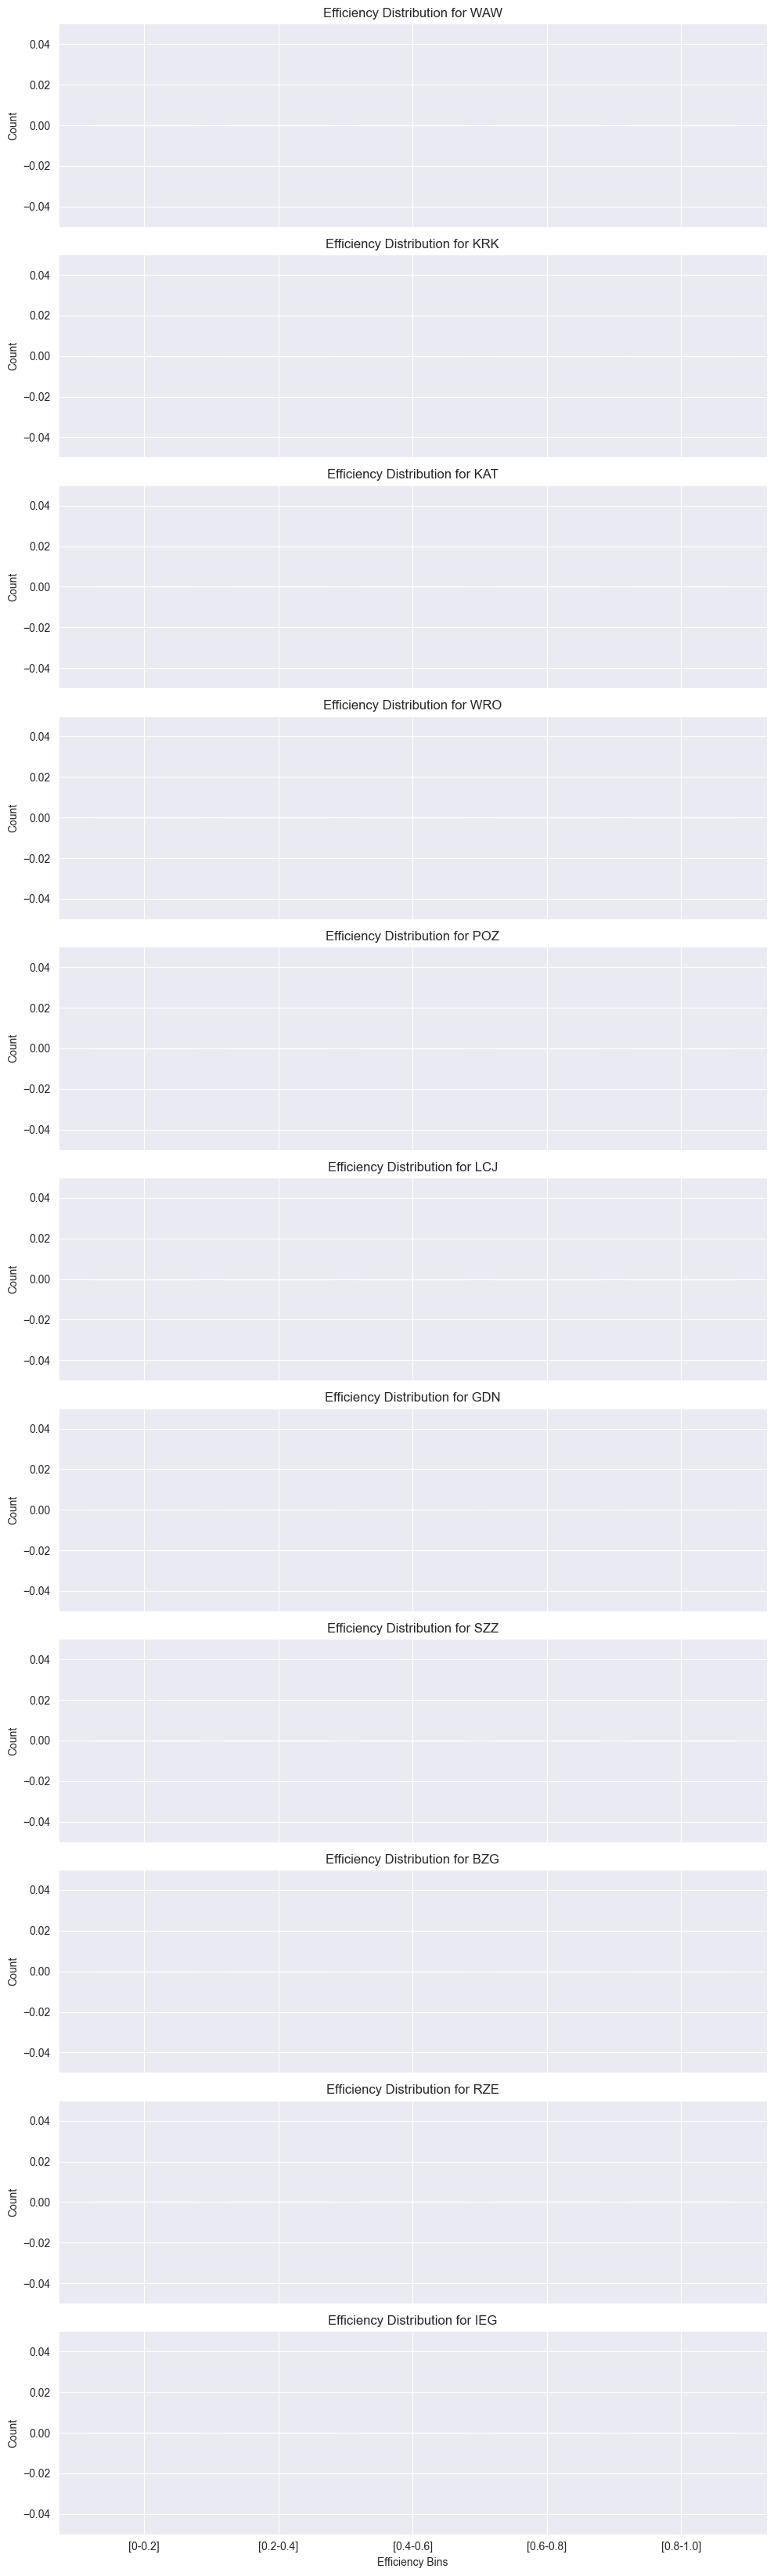

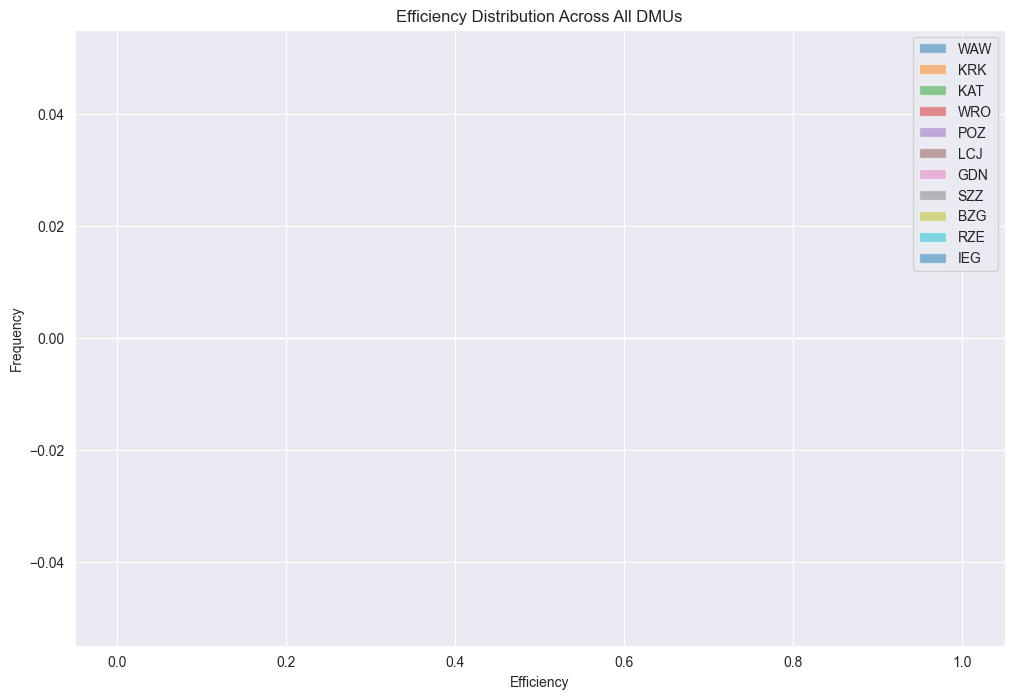

In [11]:
# Create smaller bins for better visualization
bins = np.linspace(0, 1, 6)  # Adjust the number of bins to match the table
bin_labels = ['[0-0.2]', '[0.2-0.4]', '[0.4-0.6]', '[0.6-0.8]', '[0.8-1.0]']

# Calculate efficiency distributions
efficiency_distributions = {DMU: np.histogram(cross_efficiency_scores[DMU], bins=bins)[0] for DMU in inputs.index}

# Create DataFrame for distribution
distribution_df = pd.DataFrame(efficiency_distributions).T
distribution_df.columns = bin_labels

# Add expected efficiency column
distribution_df['EE'] = distribution_df.index.map(expected_efficiency)

# Display the distribution
print("Efficiency Distribution for Each DMU:")
print(distribution_df)

# Plot the distributions for each DMU
fig, axs = plt.subplots(len(inputs.index), 1, figsize=(10, len(inputs.index)*3), sharex=True)

for idx, DMU in enumerate(inputs.index):
    axs[idx].bar(distribution_df.columns[:-1], distribution_df.loc[DMU][:-1])  # Exclude 'EE' column for plotting
    axs[idx].set_title(f'Efficiency Distribution for {DMU}')
    axs[idx].set_ylabel('Count')
    axs[idx].set_ylim(0, max(distribution_df.max()))
    axs[idx].set_xticks(range(len(bin_labels)))
    axs[idx].set_xticklabels(bin_labels)

plt.xlabel('Efficiency Bins')
plt.tight_layout()
plt.show()

# Combined histogram for all DMUs
plt.figure(figsize=(12, 8))
for DMU, efficiencies in cross_efficiency_scores.items():
    plt.hist(efficiencies, bins=bins, alpha=0.5, label=DMU)
plt.xlabel('Efficiency')
plt.ylabel('Frequency')
plt.title('Efficiency Distribution Across All DMUs')
plt.legend(loc='upper right')
plt.show()

# import ace_tools as tools; tools.display_dataframe_to_user(name="Efficiency Distribution Table", dataframe=distribution_df)
